In [15]:
import nltk, copy
import pandas as pd, numpy as np

# setup matlib plots
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# import the MNB module
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# define all stop words
stopwordsToRemove = stopwords.words("english")
mpl.style.use('ggplot')

In [2]:
# enter the root path here
rootPath = ""

# load in the dataframes
train_df = pd.read_table(rootPath+"corpus/train.tsv",sep="\t")
test_df = pd.read_table(rootPath+"corpus/test.tsv",sep="\t")

Text(0.5, 0, 'Sentiment Score')

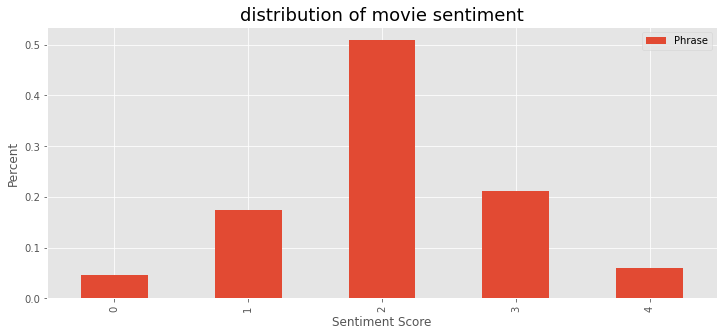

In [3]:
(train_df.groupby("Sentiment").agg(dict(Phrase="count"))/train_df.shape[0]).\
    plot(kind='bar',figsize=(12,5));
plt.title("distribution of movie sentiment",fontsize=18);
plt.ylabel("Percent")
plt.xlabel("Sentiment Score")

In [4]:
# create a stemmer and lemmatizer (both have been tried)
stemmer = SnowballStemmer('english')

# Remove all tokens of a particular POS tag
def removePosToken(phrase, remove_pos):

    # convert the string into tokens
    tokens = nltk.word_tokenize(phrase)
    
    # tag each token in the list of strings (Token)
    posTokens = nltk.pos_tag(tokens)

    # setup the list for the tokens have tokens of a particular
    # POS is removed from the original list
    modifiedtokens = []
    
    # itterate through all the pos tokens
    for posToken in posTokens:
        
        # check if the POS token is not the one we are trying to remove
        if remove_pos not in posToken[1]: 
            
            # add the good token to the list
            modifiedtokens.append(posToken[0])
            
    # join all the strings in the list back to one  big string
    return " ".join(modifiedtokens)

# remove all the stop words
def removeStopWords(phrase):
    
    # removes all the strings in the list phrase that is a stop word
    return " ".join([ w for w in phrase if w not in stopwordsToRemove])

# apply the stemmer to the data to reduce the feature size
def applyStemmer(x):
    
    # tokenize the words
    tokens = nltk.word_tokenize(x)
    
    # apply the stemmer
    tokens = [stemmer.stem(y) for y in tokens]
    
    # create a string from the tokens
    return " ".join(tokens)


# loop through both the 
for df in [train_df,test_df]:
    
    # remove all words with the POS tag RB
    df["feature_0"] = df.Phrase.apply(lambda x: removePosToken(x,"DT"))
    
    # here we will lowercase each word and than after, we will remove stop words
    df['feature_0'] = df['feature_0'].str.lower().apply(lambda x: removeStopWords(x.split(" ")))

    # apply stemmer or the lemmatizer in this case we ended up going with the lemmatizer
    df['feature_0'] = df['feature_0'].apply(lambda x: applyStemmer(x))
    
    # here we will lowercase each word and than after, we will remove stop words
    df['features_1'] = df['Phrase'].str.lower().apply(lambda x: removeStopWords(x.split(" ")))

    # apply stemmer or the lemmatizer in this case we ended up going with the lemmatizer
    df['features_1'] = df['features_1'].apply(lambda x: applyStemmer(x))

In [7]:
from sklearn.model_selection import KFold

# setup a dataframe to track the fold information
foldTracker = pd.DataFrame()
validationUpload = dict()

kf = KFold(n_splits=10, random_state=1234, shuffle=True)
fold_n = 0

# create the feature to process
for tr_idx, te_idx in kf.split(train_df["Phrase"],train_df["Sentiment"]):
    fold_n += 1
    for feature_cat in ["feature_0","features_1"]:
        
        # create the train and test variables here for the model
        tr_X, tr_y = train_df.loc[tr_idx,feature_cat], train_df.loc[tr_idx,"Sentiment"]
        te_X, te_y = train_df.loc[te_idx,feature_cat], train_df.loc[te_idx,"Sentiment"]
        
        # setup the unigram count vectorizer
        unigram_count_vectorizer =   CountVectorizer(decode_error = 'strict',
                                                     ngram_range=(1,1),
                                                     lowercase=True,
                                                     stop_words='english')

        # setup the unigram count vectorizer
        bigram_count_vectorizer = CountVectorizer(decode_error = 'strict',
                                                  ngram_range=(2,2),
                                                  lowercase=True,
                                                  stop_words='english')
        
        # setup the unigram count vectorizer
        unigram_bigram_count_vectorizer = CountVectorizer(decode_error = 'strict',
                                                          ngram_range=(1,2),
                                                          lowercase=True,
                                                          stop_words='english')
        
        for vecType, vectorizer in [("unigram",unigram_count_vectorizer), 
                                    ("bigram",bigram_count_vectorizer),
                                   ("unigram and bigram", unigram_bigram_count_vectorizer)]:
            
            # fit the unigram features
            vectorizer.fit(tr_X);

            # transform the test and train data into the features
            uni_features = vectorizer.transform(tr_X);
            uni_test_features = vectorizer.transform(te_X);
            uni_validation_features = vectorizer.transform(test_df[feature_cat]);

            # instatiate the multinomial Naive bayes model
            mdl = MultinomialNB(alpha=2)

            # fit the multinomial Naive bayes model
            mdl.fit(uni_features, tr_y)

            # print the accuracy
            y_tr_preds = mdl.predict(uni_test_features)
            
            # setup a dictionary to store all the KPIs In
            kpis = dict()
            
            # Capture all the KPIs related to the evaluation of the model
            kpis["accuracy"] = [accuracy_score(te_y, y_tr_preds)]
            kpis["precision"] = [precision_score(te_y, y_tr_preds,average="weighted")]           
            kpis["recall"] = [recall_score(te_y, y_tr_preds,average="weighted")]                 
            kpis["f1_score"] = [f1_score(te_y, y_tr_preds,average="weighted")]                       
            kpis["feature"] = [feature_cat]
            kpis["ngram"] = [vecType]
            kpis["data"]  = ["Validation"]
            kpis["foldn"]  = [fold_n]
            
            # create the string which save the probabilities for the sentiment
            validationString = feature_cat + " " + vecType
            
            # keep updating the sentiment probabilities
            if validationString not in validationUpload:
                # setup the initial predictions
                validationUpload[validationString] = mdl.predict_proba(uni_validation_features)
            else:
                # add new probabilities to the previous probabilties
                validationUpload[validationString] += mdl.predict_proba(uni_validation_features)
            
            # upload the data into the table foldTracker
            foldTracker = pd.concat([foldTracker, pd.DataFrame(kpis)])

## Evaluate each of the feature ngram combinations

In [8]:
analysisResults = foldTracker.groupby(["feature","ngram"]).mean()\
            .reset_index()\
                .sort_values("f1_score",ascending=False)\
                    .reset_index(drop=True)

analysisResults

,feature,ngram,accuracy,precision,recall,f1_score,foldn
0,feature_0,unigram and bigram,0.629847,0.617574,0.629847,0.619235,5.5
1,features_1,unigram and bigram,0.629726,0.617484,0.629726,0.619159,5.5
2,feature_0,unigram,0.609496,0.589095,0.609496,0.585617,5.5
3,features_1,unigram,0.609471,0.589060,0.609471,0.585615,5.5
4,features_1,bigram,0.608849,0.590168,0.608849,0.581690,5.5
5,feature_0,bigram,0.608836,0.590162,0.608836,0.581549,5.5


## Create predictions for the validation set

In [9]:
# get the best set
bestSet = validationUpload[analysisResults.loc[0,"feature"] + " " + analysisResults.loc[0,"ngram"]]

# create the dataframe
bestSet_df = pd.DataFrame(bestSet)

# figure out which is the most likely answer for the valudation value
def computeAnswer(x):
    
    # get the soft max distribution
    vals = x.values
    
    # get the cols assocated to each of the soft max values
    keys = np.array(list(x.index))
    
    return np.max(keys[vals == np.max(vals)])

# figure out what the most likely sentiment is
bestSet_df["prediction"] = bestSet_df.apply(lambda x: computeAnswer(x),axis=1)

# save the results to a CSV file
bestSet_df.to_csv("predictions.csv", index=False)

In [14]:
bestSet_df.head()

,0,1,2,3,4,prediction
0,0.006441,0.621994,4.148558,5.193696,0.029312,3
1,0.006441,0.621994,4.148558,5.193696,0.029312,3
2,0.453159,1.747597,5.099449,2.109894,0.589901,2
3,0.006441,0.621994,4.148558,5.193696,0.029312,3
4,0.021089,0.729925,4.218588,4.943903,0.086494,3


## Display Fold KPIs

In [10]:
foldTracker.sort_values("f1_score",ascending=False).reset_index(drop=True)

,accuracy,precision,recall,f1_score,feature,ngram,data,foldn
0,0.632834,0.620724,0.632834,0.622818,feature_0,unigram and bigram,Validation,9
1,0.632641,0.620526,0.632641,0.622610,features_1,unigram and bigram,Validation,9
2,0.633859,0.620258,0.633859,0.622447,features_1,unigram and bigram,Validation,3
3,0.633731,0.620166,0.633731,0.622332,feature_0,unigram and bigram,Validation,3
4,0.631616,0.619815,0.631616,0.622070,feature_0,unigram and bigram,Validation,4
5,0.631424,0.619751,0.631424,0.622011,features_1,unigram and bigram,Validation,4
6,0.633410,0.620361,0.633410,0.621856,feature_0,unigram and bigram,Validation,2
7,0.632962,0.619883,0.632962,0.621426,features_1,unigram and bigram,Validation,2
8,0.630783,0.619083,0.630783,0.620624,features_1,unigram and bigram,Validation,5
9,0.630591,0.618890,0.630591,0.620398,feature_0,unigram and bigram,Validation,5
